# Circuit Decomposition for Hardware-Efficient VQE#

Quantum computing is a promising technology for various applications like quantum optimization, quantum machine learning, and quantum chemistry. However, with the limited number of qubits, the limited depth of circuit, and high error rate in the two-qubit gate, near-term quantum circuits can be challenging to maintain the resultant quantum state meaningful. Such limitations severely hinders the practical applications and commercialization of quantum technology. Therefore, it's ideal to reduce the number of qubits requirement for quantum algorithms to run on the near term quantum device. In this project, we apply the quantum circuit decomposition in IBM Q Experience to demonstrate the idea of reducing the qubit number requirement for realizing the quantum optimization with VQE solver. With max-cut problem to solve, we successfully run the VQE solver on a 3 qubits circuit that, in essence, requires 4 qubits. Our circuit decomposition method is general, not bounded by the algorithms to run or number of qubits.

In [15]:
# import qiskit and other useful python modules
%matplotlib inline

#import math tools
import numpy as np
# We import the tools to handle general Graphs
import networkx as nx
# We import plotting tools 
import matplotlib.pyplot as plt 
from   matplotlib import cm
from   matplotlib.ticker import LinearLocator, FormatStrFormatter
# importing Qiskit
import qiskit as qk
import collections
import time
from qiskit.visualization import plot_histogram


# get simularto and IBMQ backends
qk.IBMQ.load_account()
provider = qk.IBMQ.get_provider(group='open')
# Run the quantum circuit on a specific backend
# BACKEND1 = provider.get_backend('ibmq_burlington')
BACKEND1 = qk.Aer.get_backend('qasm_simulator')
BACKEND2 = qk.Aer.get_backend('qasm_simulator')
backend = qk.Aer.get_backend('qasm_simulator')



Credentials are already in use. The existing account in the session will be replaced.


## Config Parameters and Constants##

In [5]:
PI = np.pi
NSHOTS = 1024 # number of measurements for each quantum circuit
SEED = int(time.time()) # Random seed for running cicuits

## Function Definitions

In [6]:
# get the projective ZmZn measurement value on result string qbs
def get_ZZ(qbs, pair):
    '''
    qbs: qubit string i.e. "0010"
    pair: ZmZn i.e. (0,1)
    '''
    qbs_r = qbs[::-1]
    return -((qbs_r[pair[0]] != qbs_r[pair[1]])-.5) * 2


In [7]:
# get the objective value of the edge pair on result string qbs
def get_max_cut_value(qbs, pair):
    '''
    qbs: qubit string i.e. "0010"
    pair: ZmZn i.e. (0,1)
    '''
    qbs_r = qbs[::-1]
    return (qbs_r[pair[0]] != qbs_r[pair[1]])

In [11]:
# generate the original, unreduced version of the max-cut quantum circuit for VQE
def make_maxcut_circuit(n, depth, thetas):
    '''
    n: number of qubits:
    depth: number of entanglements; 
    thetas: the control parameters for VQE; dimension = (n,depth)
    '''
    # parameter sanity check: check if the dimension is okay
    if isinstance(thetas, collections.Iterable) and len(thetas) >= n:
        for idx in range(n):
            if isinstance(thetas[idx], collections.Iterable) and len(thetas) >= depth: 
                pass
            else:
                raise TypeError("thetas[%d] is not an iterable or it has dimension smaller than depth = %d" % (idx,depth))
    else:
        raise TypeError("thetas is not an iterable or it has dimension smaller than n = %d" % n)
        
    # construct qubits and classical bits    
    qr = qk.QuantumRegister(n, 'q')
    cr = qk.ClassicalRegister(n, 'c')
    qc = qk.QuantumCircuit(qr, cr)
    
    for d in range(depth):
        # assign parameterized U3
        for qb in range(n):
            qc.u3(thetas[qb][d],0,0, qr[qb])
        # add barrier
        qc.barrier(qr)
        
        # pairwise control Z
        for cqb in range(n-1):
            qc.cz(qr[cqb],qr[cqb + 1])
        pass
        # add barrier
        qc.barrier(qr)
    
    # measure z
    for qb in range(n):
        qc.measure(qr[qb],cr[qb])
    return qc,qr,qc

# obtain sampling distribution from the original, unreduced version of the max-cut quantum circuit for VQE
def get_orig_maxcut_result(n,depth,default_thetas):
    '''
    n: number of qubits:
    depth: number of entanglements; 
    default_thetas: the control parameters for VQE; dimension = (n,depth)
    '''
    cc,qr,qc = make_maxcut_circuit(n,depth,default_thetas)
    {qr[0]: 0,
                     qr[1]: 1,
                     qr[2]: 2}
    job = qk.execute(cc, BACKEND1,shots=NSHOTS, seed_simulator=SEED, 
                     initial_layout={qr[0]: 0, qr[1] : 1, qr[2] : 3, qr[3] : 4})
    result = job.result()
    ddict = result.get_counts(0)
    for idx in range(2 ** n):
        if not (format(idx, "0%db" % n) in ddict):
            ddict[format(idx,'0%db'% n)] = 0
    return ddict

In [12]:
# obtain sampling distribution from the reduced version of the max-cut quantum circuit for VQE
def get_reduced_maxcut_result(n, depth, thetas):
    '''
    returns the result in n qubit space
    by default the qubit to be disconnected is the last qubit with index n-1
    n: number of qubits:
    depth: number of entanglements; 
    default_thetas: the control parameters for VQE; dimension = (n,depth)
    '''
    # parameter sanity check: check if the dimension is okay
    if isinstance(thetas, collections.Iterable) and len(thetas) >= n:
        for idx in range(n):
            if isinstance(thetas[idx], collections.Iterable) and len(thetas) >= depth: 
                pass
            else:
                raise TypeError("thetas[%d] is not an iterable or it has dimension smaller than depth = %d" % (idx,depth))
    else:
        raise TypeError("thetas is not an iterable or it has dimension smaller than n = %d" % n)
        
    # construct container for n-1 qubit results
    final_result = {}
    for idx in range(2 ** n):
        final_result[format(idx,'0%db'% n)] = 0
  
    counts = [0 for i in range(6 ** depth)] # keeps track of all the counts of all the power of 
    for runid in range(6 ** depth):
        # the index of the version at each two qubit gate we split
        cc_cnts = [ (runid % (6 ** (idx + 1))) // (6 ** idx) for idx in range(depth)]
        # construct qubits and classical bits
        qr = qk.QuantumRegister(n-1, 'q')
        cr = qk.ClassicalRegister(n-1+depth, 'c')
        qc = qk.QuantumCircuit(qr, cr)
        qc2 =qk.QuantumCircuit(1, 1+depth) 
      
        #coef for each runid
        coef = 1

        for d in range(depth):
            # assign parameterized U3
            for qb in range(n-1):
                qc.u3(thetas[qb][d],0,0, qr[qb])
            qc2.u3(thetas[-1][d],0,0, 0)
            
            # add barrier
            qc.barrier(qr)
            qc2.barrier([0])

            # pairwise control Z
            for cqb in range(n-2):
                qc.cz(qr[cqb],qr[cqb + 1])
            
            # add the virtual two qubit gate on the last qubit
            gate_ver = cc_cnts[d] + 1
            qa = qr[-1]
            qb = 0
            if gate_ver == 1:
                coef *= 1/2
            elif gate_ver == 2:
                qc.z(qa)
                qc2.z(qb)
                coef *= 1/2
            elif gate_ver == 3:
                qc.measure(qa, cr[n-1+d])
                qc2.rz(-np.pi * 1 / 2, qb)
    
                coef *= -1/2*1
            elif gate_ver == 4:
                qc.measure(qa, cr[n-1+d])
                qc2.rz(-np.pi * -1 / 2, qb)
    
                coef *= -1/2*-1
            elif gate_ver == 5:
                qc2.measure(qb, 1+d)
                qc.rz(-np.pi * 1 / 2, qa)
    
                coef *= -1/2*1
            elif gate_ver == 6:
                qc2.measure(qb, 1+d)
                qc.rz(-np.pi * -1 / 2, qa)
    
                coef *= -1/2*-1
            
            qc.rz(-np.pi/2,qa)
            qc2.rz(-np.pi/2,qb)
            qc.barrier(qr)
            qc2.barrier([0])
    
        # measure z
        for qb in range(n-1):
            qc.measure(qr[qb],cr[qb])
        qc2.measure([0], [0])
    
        # execute experiments
        job_tmp_1 = qk.execute(qc, BACKEND1,shots=NSHOTS, seed_simulator=SEED)
        job_tmp_2 = qk.execute(qc2, BACKEND2,shots=NSHOTS, seed_simulator=SEED)
        result_tmp_2 = job_tmp_2.result()
        result_tmp_1 = job_tmp_1.result()
        dict_1 = result_tmp_1.get_counts(0)
        dict_2 = result_tmp_2.get_counts(0)
        
        # post-process six individual measurement results and tensor two subcircuit results
        for key1 in dict_1:
            coef1 = 1
            for i in key1[0:depth]:
                coef1 *= 1-int(i)*2
            for key2 in dict_2:
                coef2 = 1
                for i in key2[0:depth]:
                    coef2 *= 1-int(i)*2
                key = key2[depth:] + key1[depth:]
                final_result[key] += coef*coef1*coef2*dict_1[key1]*dict_2[key2]
    return final_result

In [13]:
# get the cost function/ising Hamiltonian value used for the SPSA algorithm
def get_cost(data, w):
    '''
    data: sampling distribution of the circuit
    w: weights for the max cut problem
    '''
    d = len(w)
    cnt = np.sum(list(data.values()))
    cost = 0
    for mm in range(d):
        for nn in range(mm+1,d):
            cost += w[mm][nn] * np.sum([get_max_cut_value(val,(mm,nn)) * data[val] for val in data])
    return cost / cnt

In [14]:
# this is a modifed version of the get_reduced_maxcut_result function for the IBM Q Chips; 
# we have to do this because the current IBMQ devices does not allow gates to occur
# after measurement. This function can work for circuit of depth 1 on real IBM Q chips
def get_real_device_reduced_maxcut_result(n, depth, thetas):
    '''
        returns the result in n qubit space
        by default the qubit to be disconnected is the last qubit with index n-1
        n: number of qubits:
        depth: number of entanglements; 
        default_thetas: the control parameters for VQE; dimension = (n,depth)
    '''
    # parameter sanity check: check if the dimension is okay
    if isinstance(thetas, collections.Iterable) and len(thetas) >= n:
        for idx in range(n):
            if isinstance(thetas[idx], collections.Iterable) and len(thetas) >= depth: 
                pass
            else:
                raise TypeError("thetas[%d] is not an iterable or it has dimension smaller than depth = %d" % (idx,depth))
    else:
        raise TypeError("thetas is not an iterable or it has dimension smaller than n = %d" % n)
        
    # construct container for n-1 qubit results
    final_result = {}
    for idx in range(2 ** n):
        final_result[format(idx,'0%db'% n)] = 0
  
    counts = [0 for i in range(6 ** depth)] # keeps track of all the counts of all the power of 
    for runid in range(6 ** depth):
        # the index of the version at each two qubit gate we split
        cc_cnts = [ (runid % (6 ** (idx + 1))) // (6 ** idx) for idx in range(depth)]
        # construct qubits and classical bits
        qr = qk.QuantumRegister(n-1, 'q')
        cr = qk.ClassicalRegister(n-1, 'c')
        qc = qk.QuantumCircuit(qr, cr)
        qc2 =qk.QuantumCircuit(1, 1) 
      
        #coef for each runid
        coef = 1

        for d in range(depth):
            # assign parameterized U3
            for qb in range(n-1):
                qc.u3(thetas[qb][d],0,0, qr[qb])
            qc2.u3(thetas[-1][d],0,0, 0)
            
            # add barrier
            qc.barrier(qr)
            qc2.barrier([0])

            # pairwise control Z
            for cqb in range(n-2):
                qc.cz(qr[cqb],qr[cqb + 1])
            
            # add the virtual two qubit gate on the last qubit
            gate_ver = cc_cnts[d] + 1
            qa = qr[-1]
            qb = 0
            if gate_ver == 1:
                coef *= 1/2
            elif gate_ver == 2:
                qc.z(qa)
                qc2.z(qb)
                coef *= 1/2
            elif gate_ver == 3:
                #qc.measure(qa, cr[n-1+d])
                qc2.rz(-np.pi * 1 / 2, qb)
    
                coef *= -1/2*1
            elif gate_ver == 4:
                #qc.measure(qa, cr[n-1+d])
                qc2.rz(-np.pi * -1 / 2, qb)
    
                coef *= -1/2*-1
            elif gate_ver == 5:
                #qc2.measure(qb, 1+d)
                qc.rz(-np.pi * 1 / 2, qa)
    
                coef *= -1/2*1
            elif gate_ver == 6:
                #qc2.measure(qb, 1+d)
                qc.rz(-np.pi * -1 / 2, qa)
    
                coef *= -1/2*-1
            
            qc.rz(-np.pi/2,qa)
            qc2.rz(-np.pi/2,qb)
            qc.barrier(qr)
            qc2.barrier([0])
    
        # measure z
        for qb in range(n-1):
            qc.measure(qr[qb],cr[qb])
        qc2.measure([0], [0])
    
        # execute experiments
        job_tmp_1 = qk.execute(qc, BACKEND1,shots=NSHOTS, seed_simulator=SEED)
        job_tmp_2 = qk.execute(qc2, BACKEND2,shots=NSHOTS, seed_simulator=SEED)
        result_tmp_2 = job_tmp_2.result()
        result_tmp_1 = job_tmp_1.result()
        dict_1 = result_tmp_1.get_counts(0)
        dict_2 = result_tmp_2.get_counts(0)
        
        
        gate_ver = runid + 1
        for key1 in dict_1:
            coef1 = 1
            if gate_ver == 3 or gate_ver == 4:
                coef1 = 1-int(key1[0])*2
            for key2 in dict_2:
                coef2 = 1
                if gate_ver == 5 or gate_ver == 6:
                    coef1 = 1-int(key2[0])*2
                #print(key2[depth:], ' ', key2[-1])
                key = key2 + key1
                #print(key)
                final_result[key] += coef*coef1*coef2*dict_1[key1]*dict_2[key2]
    #print(final_result)
    return final_result

## Single-Shot Sampling Distribution Comparison of the Two Algorithsm##

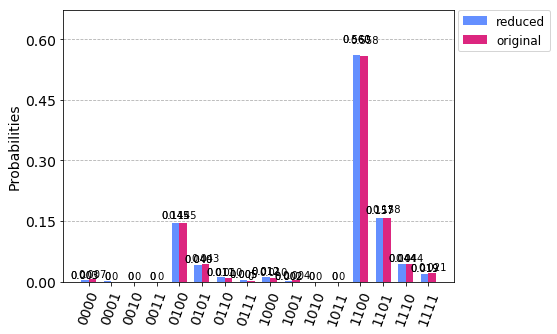

In [16]:
default_thetas = [[ np.random.rand()*5 for j in range(4)] for i in range(4)]
SEED = 11312
NSHOTS = 1024
final_result = get_orig_maxcut_result(4, 1, default_thetas)
final_result_reduced = get_real_device_reduced_maxcut_result(4,1,default_thetas)
from qiskit.visualization import plot_histogram
plot_histogram([final_result_reduced,final_result], legend=["reduced","original"])

## SPSA Optimization Utility ## 

In [17]:
# the simultaneous perturbation stochastic approximation (SPSA) method
# described in https://en.wikipedia.org/wiki/Simultaneous_perturbation_stochastic_approximation 
def SPSA_optimization(n, depth, total_test, w,get_result_func):
    '''
    n: number of qubits
    depth: depth of the circuit
    total_test: the number of iterations
    w: the weights of the max-cut graph
    get_result_func: a function reference for choosing the appropriate algorithms
    '''
    
    # the following global definitions are in place because
    # we still want to access the last running result
    # in case any error occurs during optimizatrion
    global F
    global results 
    L = n*depth
    beta = np.ones((L, 1))
    for i in range(0, L):
        beta[i] = 1
    param = [[np.random.rand()*5 for j in range(depth)] for i in range(n)]
    for T in range(1, total_test+1):
        an = 1.2 / np.power(T, 0.6)
        cn = 0.3 / np.power(T, 1)
        delta = np.random.binomial(1, 0.5, L)*2-1
        #print(delta)
        total = 0 
        for i in range(n):
            for j in range(depth):
                param[i][j] = beta[total] + delta[total]*cn
                total = total + 1
        
        final_result = get_result_func(n, depth, param)
        F_plus = get_cost(final_result, w)
        
        total = 0
        for i in range(n):
            for j in range(depth):
                param[i][j] = beta[total] - delta[total]*cn
                total = total + 1
        
        final_result = get_result_func(n, depth, param)
        F_minus = get_cost(final_result, w)
        
        for i in range(L):
            beta[i] += an * (F_plus - F_minus) / (2*cn*delta[i])
        F.append(F_minus)
        print(T, ": ", F_minus)
        results = final_result

In [19]:
SEED = int(time.time())
w = [[0., 1., 1., 1.],[1., 0., 1., 0.],[1., 1., 0., 1.],[1., 0., 1., 0.]]
F = []
results = []
SPSA_optimization(4, 1, 10, w, get_real_device_reduced_maxcut_result)

1 :  1.359466552734375
2 :  2.1685791015625
3 :  2.09417724609375
4 :  2.4033584594726562
5 :  3.2052841186523438
6 :  3.2914505004882812
7 :  3.2616653442382812
8 :  3.3887939453125
9 :  3.4315872192382812
10 :  3.8064002990722656


{'0000': 986.0, '0001': 10846.0, '0010': 0, '0011': 0, '0100': 73950.0, '0101': 903176.0, '0110': 2958.0, '0111': 17748.0, '1000': 38.0, '1001': 418.0, '1010': 0, '1011': 0, '1100': 2850.0, '1101': 34808.0, '1110': 114.0, '1111': 684.0}


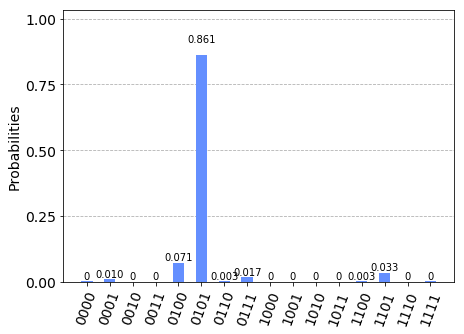

In [21]:
print(results)
plot_histogram(results)